# Aaaahhhhhhhh
Alle guten Dinge sind zwei, also mal schauen ob ichs jetzt richtig verstanden hab.

- Fix geometry
- Vary the B.n created by plasma (B_external_normal)
- Analyze the impact

virtual casing data file: tests/test_files/vcasing_W7-X_without_coil_ripple_beta0p05_d23p4_tm_reference.nc
Loading saved virtual casing result


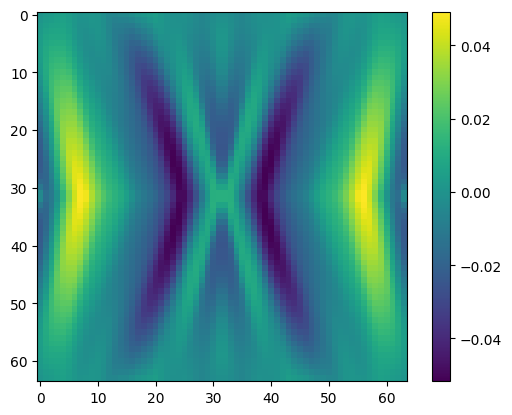

Text(0.5, 1.0, 'Spectrum of the loaded B.n')

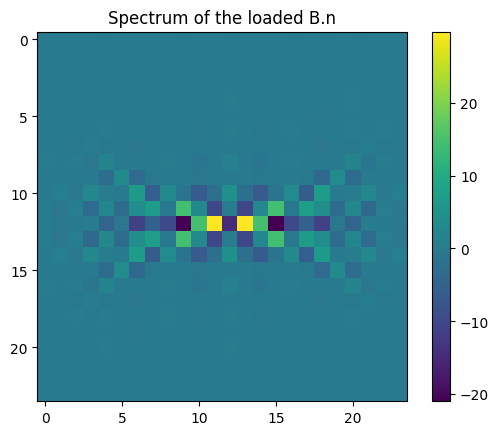

In [305]:
import os
from datetime import datetime
from pathlib import Path
import numpy as np
from scipy.optimize import minimize
from simsopt.field import BiotSavart, Current, coils_via_symmetries
import simsopt.geo
from simsopt.mhd import VirtualCasing, Vmec
from simsopt.objectives import QuadraticPenalty, SquaredFlux
from simsopt.util import in_github_actions


# Major radius for the initial circular coils:
R0 = 5.5

# Minor radius for the initial circular coils:
R1 = 1.25
R1_reactor = R0/5

# Number of Fourier modes describing each Cartesian component of each coil:
order = 6

# Number of iterations to perform:
MAXITER = 75

# File for the desired boundary magnetic surface:
TEST_DIR = "tests/test_files"
filename = 'wout_W7-X_without_coil_ripple_beta0p05_d23p4_tm_reference.nc'
vmec_file = TEST_DIR +"/"+ filename

# Resolution on the plasma boundary surface:
# nphi is the number of grid points in 1/2 a field period.
nphi = 32
ntheta = 64

# Resolution for the virtual casing calculation:
vc_src_nphi = 80
# (For the virtual casing src_ resolution, only nphi needs to be
# specified; the theta resolution is computed automatically to
# minimize anisotropy of the grid.)

#######################################################
# End of input parameters.
#######################################################

# Directory for output
out_dir = Path("output")
out_dir.mkdir(parents=True, exist_ok=True)

# Once the virtual casing calculation has been run once, the results
# can be used for many coil optimizations. Therefore here we check to
# see if the virtual casing output file alreadys exists. If so, load
# the results, otherwise run the virtual casing calculation and save
# the results.
head, tail = os.path.split(vmec_file)
vc_filename = os.path.join(head, tail.replace('wout', 'vcasing'))
print('virtual casing data file:', vc_filename)
if os.path.isfile(vc_filename):
    print('Loading saved virtual casing result')
    vc = VirtualCasing.load(vc_filename)
else:
    # Virtual casing must not have been run yet.
    print('Running the virtual casing calculation')
    vc = VirtualCasing.from_vmec(vmec_file, src_nphi=vc_src_nphi, trgt_nphi=nphi, trgt_ntheta=ntheta)

import matplotlib.pyplot as plt
stacked_img = np.vstack([vc.B_external_normal, np.flip(vc.B_external_normal, axis=0)])
extended_img = np.hstack([stacked_img, np.flip(stacked_img, axis=1)])
plt.imshow(extended_img)
plt.colorbar()
plt.show()
plt.imshow(np.real(np.fft.ifftshift(np.fft.fft2(extended_img))[20:-20,20:-20]))
plt.colorbar()
plt.title("Spectrum of the loaded B.n")

In [ ]:
s = simsopt.geo.SurfaceRZFourier.from_nphi_ntheta(32, 32, "field period", 5)
s.set_rc(0,0,R0)
s.set_rc(1,0,R1_reactor)
s.set_zs(1,0,R1_reactor)
s.plot()
print("Aspect ratio",R0/R1_reactor)

In [22]:
def plot_modes(image_mn, **kwargs):
  extent = (-image_mn.shape[1]/2, image_mn.shape[1]/2, image_mn.shape[0]-0.5,-0.5)

  plt.imshow(image_mn, extent=extent, **kwargs)
  plt.colorbar()
  plt.ylabel("m")
  plt.xlabel("n")

Only contains the even terms, for odd terms the imaginary equivalent has to be used! 

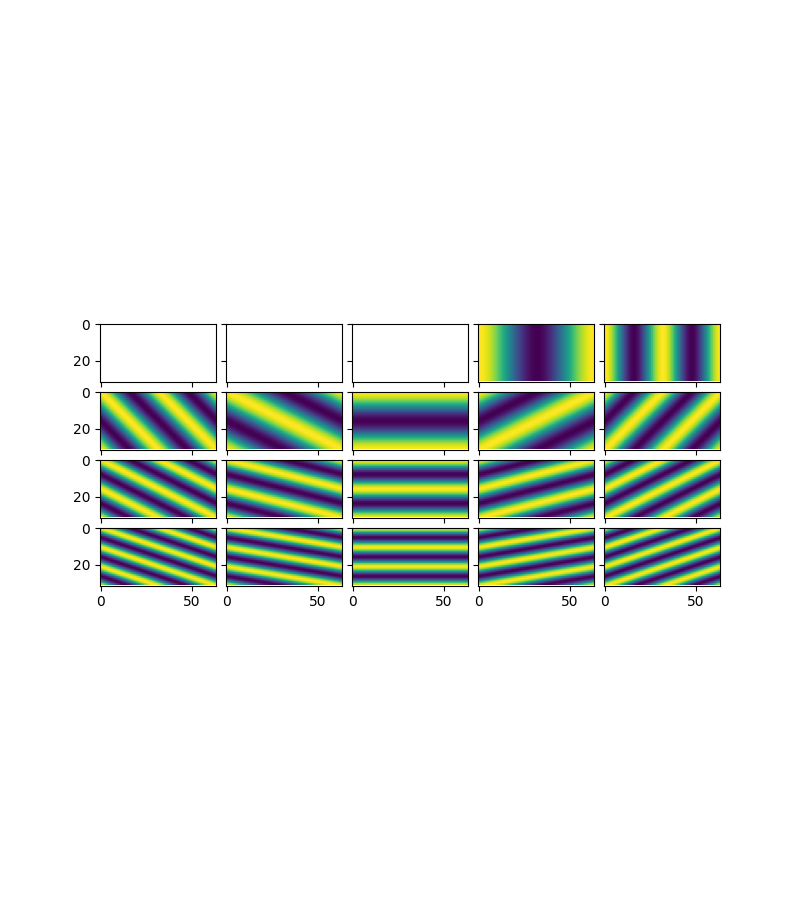

In [333]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

Mpol_max = 4
Ntor_max = 3

images = []
ms = []
ns = []
for m in range(Mpol_max):
  for sig_n in [-1, 1]:
    if m==0 and sig_n==-1:
      images.extend([None]*(Ntor_max-1))
      continue
    for n in range(Ntor_max) if sig_n>0 else reversed(range(1,Ntor_max)):
      if m==0 and n==0:
         images.append(None)
         continue
      Bn_fspace = np.zeros((nphi, ntheta))
      Bn_fspace[m][n*sig_n] = nphi*10
      B_external_normal = np.fft.ifft2(Bn_fspace)

      images.append(np.real(B_external_normal))
      ms.append(m)
      ns.append(n*sig_n)

fig = plt.figure(figsize=(Mpol_max*2, Ntor_max*3))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(Mpol_max, Ntor_max*2-1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    if im is not None:
      ax.imshow(im)
plt.show()

images = list(filter(lambda x: x is not None, images))

In [24]:
import ipywidgets

def plot_coil_complexities(campaign_folder):
    resfilepaths = os.listdir(campaign_folder)

    results = [simsopt.load(os.path.join(campaign_folder, resfile)) for resfile in resfilepaths]
    mmax = 0
    nmax = 0
    for res in results:
        mmax = max(mmax, res["m"])
        nmax = max(nmax, res["n"])
    heatmap_convergence_mean = np.zeros((mmax+1, nmax*2+1))
    heatmap_convergence_max = np.zeros((mmax+1, nmax*2+1))
    coil_complexity_map = np.zeros_like(heatmap_convergence_mean)
    J_map = np.zeros_like(heatmap_convergence_mean)
    
    for res in results:
        heatmap_convergence_mean[res["m"]][nmax+res["n"]] = np.mean(np.abs(res["BdotN"]))
        heatmap_convergence_max[res["m"]][nmax+res["n"]] = np.max(res["BdotN"])
        J_map[res["m"]][nmax+res["n"]] = res["J"]
        
        if res["J"] < B_DOT_N_THRESHOLD:
            coil_complexity_map[res["m"]][nmax+res["n"]] = res["complexity"]
        else:
            coil_complexity_map[res["m"]][nmax+res["n"]] = np.nan 
    plt.subplot(221)
    plot_modes(heatmap_convergence_mean)
    plt.title("Mean B.n error")
    plt.subplot(222)
    plot_modes(heatmap_convergence_max)
    plt.title("Max B.n error")
    plt.subplot(223)
    plot_modes(coil_complexity_map)
    plt.title("coil_complexity_map")
    plt.subplot(224)
    plot_modes(J_map)
    plt.title("J")
    plt.savefig("complexity.png")

    # for res in results:
    #     simsopt.geo.plot(res["coils"])

directories = [os.path.join(out_dir, name) for name in os.listdir(out_dir) if os.path.isdir(os.path.join(out_dir, name))]
ipywidgets.interact(plot_coil_complexities, campaign_folder=ipywidgets.Dropdown(options=reversed(directories)))


interactive(children=(Dropdown(description='campaign_folder', options=('output/2024-05-12--19-01', 'output/202…

<function __main__.plot_coil_complexities(campaign_folder)>

## Sensitivity analysis

In [334]:
def image_from_magn_and_phase(magnitudes, phases, image_size=(64, 64)):
    # Construct frequency domain signal
    # magnitudes[0] = 0
    freq_signal = magnitudes * nphi * np.exp(1j * phases)
    
    # Perform 2D inverse Fourier transform
    image = np.fft.ifft2(freq_signal, s=image_size)

    # plt.subplot(131)
    # plt.imshow(np.fft.fftshift(np.abs(image)))
    # plt.subplot(132)
    # plt.imshow(np.fft.fftshift(np.angle(image)))

    # Take real part of the image
    return np.real(image)

# Generate random magnitudes and phases
magnitudes = np.random.rand(Mpol_max, Ntor_max)
phases = np.random.rand(Mpol_max, Ntor_max)  * 2 * np.pi
image_from_magn_and_phase(magnitudes, phases)

array([[ 0.00956978,  0.0113579 ,  0.01337826, ...,  0.00614577,
         0.00692134,  0.00807457],
       [ 0.01231303,  0.01434173,  0.01654733, ...,  0.00797903,
         0.00907406,  0.01053578],
       [ 0.01422935,  0.016393  ,  0.01866358, ...,  0.00918842,
         0.01055594,  0.01225804],
       ...,
       [-0.00111348, -0.00043648,  0.00051324, ..., -0.00142152,
        -0.00160523, -0.00150438],
       [ 0.00257984,  0.00366234,  0.005027  , ...,  0.0012569 ,
         0.00136523,  0.00180824],
       [ 0.0062354 ,  0.00769883,  0.00943058, ...,  0.00384438,
         0.00428149,  0.00508523]])

In [335]:
out_dir_campaign = out_dir / datetime.now().strftime("%Y-%m-%d--%H-%M") #For the current experimental campaign
out_dir_campaign.mkdir(parents=True, exist_ok=True)
print(out_dir_campaign)

def problem(Bmagnitude, Bphase, complex_surface=False, stellsym=False, batch=False):
    nfp = 3
    
    target_field = image_from_magn_and_phase(Bmagnitude, Bphase, (nphi, ntheta))

    if stellsym:
        nphi_asym = nphi
        ncoils = 3
    else:
        nphi_asym = nphi*2
        ncoils = 6
        #B_external_normal = target_field if stellsym else np.vstack([target_field, np.flip(target_field, axis=0)])
        B_external_normal = target_field if stellsym else np.vstack([target_field, target_field])

    # Generate Geometry from X2 parameter
    if complex_surface:
        filename = "tests/test_files/input.LandremanPaul2021_QA"
        s = simsopt.geo.SurfaceRZFourier.from_vmec_input(filename, nphi=nphi_asym, ntheta=ntheta)
    else:
        s = simsopt.geo.SurfaceRZFourier.from_nphi_ntheta(nphi_asym, ntheta, range="half period" if stellsym else "field period", nfp=nfp)
        
        s.change_resolution(max(ms), max(ns))
        
        s.set_rc(0,0,R0)
        s.set_rc(1,0,R1_reactor)
        s.set_zs(1,0,R1_reactor)
        # mask = s.rc < 0.0
        # mask[0,:s.ntor+1] = True
        # s.rc[~mask] += X2
    
    normalization_weight = np.sqrt(s.area()/(2 * np.pi**2 *np.linalg.norm(s.normal(), axis=-1)))
    B_external_normal = normalization_weight * B_external_normal 

    if(not batch):
        plt.figure()
        plt.subplot(221)
        plt.imshow(B_external_normal)
        plt.colorbar()
        plt.title("Target field")

    CS_THRESHOLD = 0.02
    # Create the initial coils:
    base_curves = simsopt.geo.create_equally_spaced_curves(ncoils, s.nfp, stellsym=stellsym, R0=s.major_radius(), R1=s.minor_radius()*(1+2*CS_THRESHOLD), order=order)
    base_currents = [Current(5e6 / ncoils * 1e-5) * 1e5 for _ in range(ncoils)]
    # Above, the factors of 1e-5 and 1e5 are included so the current
    # degrees of freedom are O(1) rather than ~ MA.  The optimization
    # algorithm may not perform well if the dofs are scaled badly.

    coils = coils_via_symmetries(base_curves, base_currents, s.nfp, stellsym=stellsym)
    bs = BiotSavart(coils)
    bs.set_points(s.gamma().reshape((-1, 3)))
    curves = [c.curve for c in coils]

    # Form the total objective function.
    B_DOT_N_THRESHOLD = 0.05  # 10% error allowed
    LENGTH_WEIGHT = 0.03
    CC_THRESHOLD = 0.2
    CURVATURE_THRESHOLD = 0.2
    CURVATURE_WEIGHT = 0.5
    
    Jf_initial = SquaredFlux(s,BiotSavart([]), target=B_external_normal).J() # Scalar evaluation to create the percentage error threshold

    Jf = 2*SquaredFlux(s, bs, target=B_external_normal)
    Jf_threshold =  10*QuadraticPenalty(Jf, B_DOT_N_THRESHOLD*Jf_initial, "max")
    Jls = QuadraticPenalty(LENGTH_WEIGHT*sum([simsopt.geo.CurveLength(c) for c in base_curves]))
    Jccdist = simsopt.geo.CurveCurveDistance(curves, CC_THRESHOLD, num_basecurves=ncoils)
    Jcsdist = simsopt.geo.CurveSurfaceDistance(curves, s, CS_THRESHOLD)
    Jcs = CURVATURE_WEIGHT * sum([simsopt.geo.LpCurveCurvature(c, 2, CURVATURE_THRESHOLD) for c in base_curves])
    # Jmscs = MSC_WEIGHT * sum( [simsopt.geo.MeanSquaredCurvature(c) for c in base_curves])
    
    JF = Jf  + Jf_threshold + Jls + Jccdist  + Jcsdist  + Jcs \
        #+ MSC_WEIGHT * sum(Jmscs)
       

    def fun(dofs):
        JF.x = dofs
        J = JF.J()
        grad = JF.dJ()
        return J, grad

    res = minimize(fun, JF.x, jac=True, method='L-BFGS-B', options={'maxiter': MAXITER, 'maxcor': 300, 'ftol': 1e-20, 'gtol': 1e-20}, tol=1e-20)
    dofs = res.x

    # Writing to file
    Bbs = bs.B().reshape((nphi_asym, ntheta, 3))
    BdotN = np.sum(Bbs * s.unitnormal(), axis=2) - B_external_normal
    pointData = {"B_N": BdotN[:, :, None]}
    s.to_vtk(out_dir / "surf_opt", extra_data=pointData)
    simsopt.geo.curves_to_vtk(curves, out_dir / "curves_opt")
    
    def get_unique_filename(filename):
        if not os.path.exists(filename):
            return filename

        # Split the filename and its extension
        name, ext = os.path.splitext(filename)

        # Initialize counter
        counter = 1

        # Increment the filename until it is unique
        while True:
            new_filename = f"{name}_{counter}{ext}"
            if not os.path.exists(new_filename):
                return new_filename
            counter += 1

    complexity = (JF.J() - Jf.J() - Jf_threshold.J()) # only the coil complexity terms, without the magnetic field residual
    simsopt.save({  "Bmagnitude":Bmagnitude,
                    "Bphase":Bphase,
                    "J": JF.J(),
                    "complexity": complexity,
                    "coils":coils,
                    "surf":s,
                    "B_external_normal":B_external_normal,
                    "BdotN":BdotN}, 
                    get_unique_filename(out_dir_campaign/"sens_result.json"))
    
    if(not batch):
        plt.subplot(223)
        plt.imshow(np.real(np.sum(Bbs * s.unitnormal(), axis=2)))
        plt.colorbar()
        plt.title("B.n realized")

        plt.subplot(122)
        plt.imshow(np.real(BdotN))
        plt.colorbar()
        plt.title("B.n Diff")

        plt.show()

        simsopt.geo.plot([s]+curves)

        print("Jf",Jf.J())
        print("Jf_threshold",Jf_threshold.J())
        print("Jls",Jls.J())
        print("Jccdist",Jccdist.J())
        print("Jcsdist",Jcsdist.J())
        print("Jcs",Jcs.J())
        # print("Jmscs",Jmscs.J())

    return complexity, np.mean(np.abs(BdotN))

counter = 0
def debug_func(X,X2, **kwargs):
    global counter

    plt.subplot(4,4,(counter%16+1))
    plt.imshow(image_from_magn_and_phase(X, X2))
    counter+=1
    if(counter%16 == 0):
        plt.colorbar()
        plt.show()
        
    return np.mean(X), np.max(X)

def wrapped_problem(X: np.ndarray, func=problem) -> np.ndarray:
    N, D = X.shape
    results = []
    for i in range(N):
        print(f"{i+1}/{N}")
        magn = np.concatenate([[0],X[i, :]]).reshape((Mpol_max, Ntor_max))
        phase = np.random.rand(*magn.shape)*np.pi*2 #np.concatenate([[0],X[i, D//2:]]).reshape((Mpol_max, Ntor_max))
        results.append(func(magn, 
                            phase, 
                            batch=True))

    return np.array(results)

output/2024-05-14--16-36


In [336]:
import numpy as np
from SALib import ProblemSpec

sp = ProblemSpec({
        "names":  list(map(lambda x: "M"+str(x), range(1,Mpol_max* Ntor_max))), #+list(map(lambda x: "P"+str(x), range(1,Mpol_max* Ntor_max))) ,
        "bounds": [[0, 60]]  * (Mpol_max* Ntor_max-1), # + [[0, 2*np.pi]]  * (Mpol_max* Ntor_max-1),
        "outputs": ["coil_complexity", "BdotN_mean"],
    })

sp.sample_sobol(8, calc_second_order=True).evaluate(wrapped_problem).analyze_sobol()

1/192
2/192


/home/IPP-HGW/juph/efficient-fields/.venv/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/home/IPP-HGW/juph/efficient-fields/.venv/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/home/IPP-HGW/juph/efficient-fields/.venv/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))
/home/IPP-HGW/juph/efficient-fields/.venv/lib/python3.11/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a S

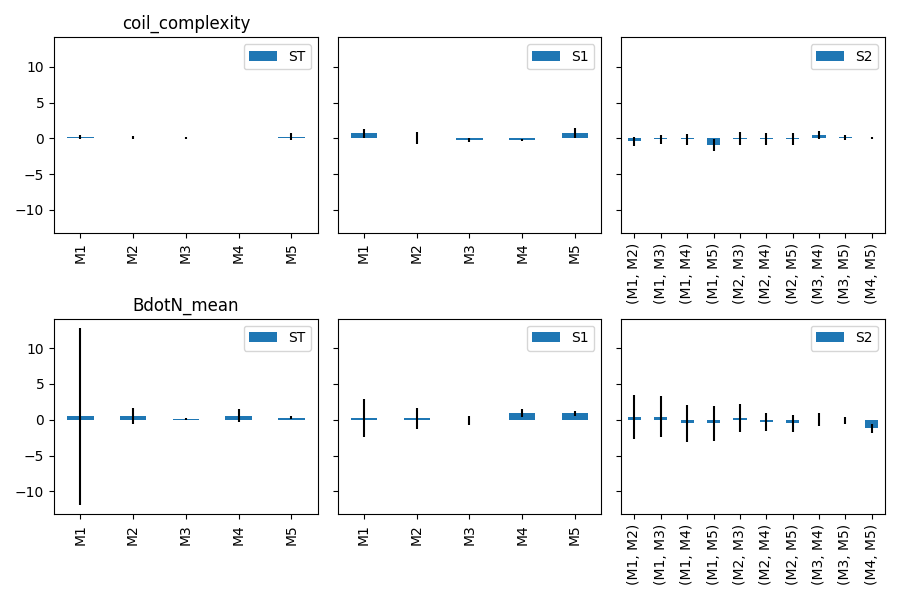

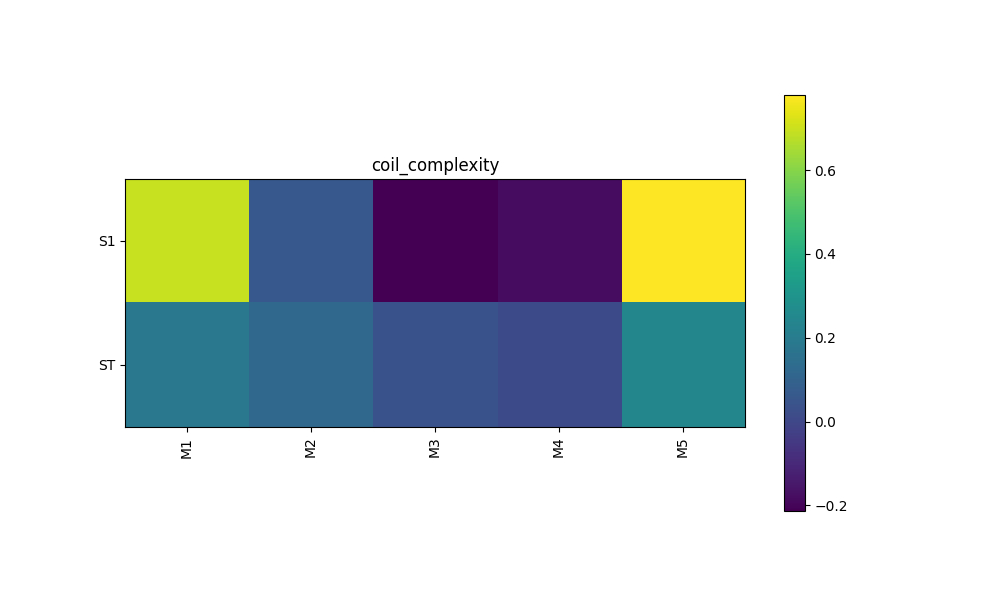

In [327]:
%matplotlib widget
import pandas as pd
sp.plot()
sp.heatmap()
complexity_Si, BdotN_Si = sp.to_df()
complexity_Si[0].to_csv("total_Si_complex_landreman.csv")
BdotN_Si[0].to_csv("total_Si_BdotN_landreman.csv")
complexity_Si[1].to_csv("first_Si_complex_landreman.csv")
BdotN_Si[1].to_csv("first_Si_BdotN_landreman.csv")
complexity_Si[2].to_csv("second_Si_complex_landreman.csv")
BdotN_Si[2].to_csv("second_Si_BdotN_landreman.csv")

In [320]:
import sys
import os
import simsopt

results = []
for path in os.listdir("output/2024-05-14--16-12"):
  optimization_res = simsopt.load("output/2024-05-14--16-12/" +path)
  results.append(optimization_res)

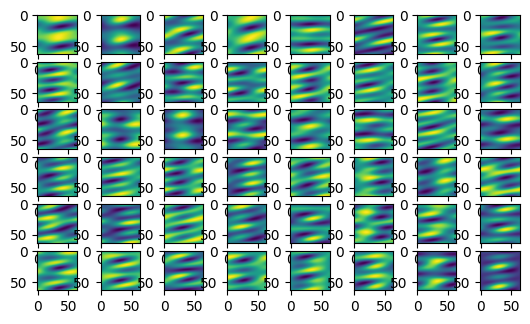

In [326]:
import matplotlib.pyplot as plt
%matplotlib inline
i = 0
for optimization_res in results:
  # simsopt.geo.plot([optimization_res["surf"]]+optimization_res["coils"])
  plt.subplot(8,8,(i%64+1))
  plt.imshow(optimization_res["B_external_normal"])
  i+=1
  if(i%64 == 0):
    plt.show()
  # {  "X":X,
  #   "J": JF.J(),
  #   "complexity": complexity,
  #   "coils":coils,
  #   "surf":s,
  #   "B_external_normal":B_external_normal,
  #   "BdotN":BdotN}, 
  

## CSV analysis

In [328]:
import pandas as pd
import plotly.express as px

# complexity_Si, BdotN_Si = sp.to_df()
# complexity_Si[0].to_csv("total_Si_complex.csv")
# BdotN_Si[0].to_csv("total_Si_BdotN.csv")
# complexity_Si[1].to_csv("first_Si_complex.csv")
# BdotN_Si[1].to_csv("first_Si_BdotN.csv")
# complexity_Si[2].to_csv("second_Si_complex.csv")
# BdotN_Si[2].to_csv("second_Si_BdotN.csv")

first_Si_complexity = pd.read_csv("first_Si_complex_landreman.csv", index_col=0)
first_Si_BdotN = pd.read_csv("first_Si_BdotN_landreman.csv", index_col=0)

In [331]:
def implot_df(df:pd.DataFrame):
  df["mn"] = df.index.to_series().apply(lambda x: int(x.replace("M","")))
  df["m"] = df["mn"].map(pd.Series(ms))
  df["n"] = df["mn"].map(pd.Series(ns))
  df["geometry"] = df.index.to_series().apply(lambda x: x.count("M")>0)

  df_G = df[df["geometry"]]
  df_B = df[~df["geometry"]]

  px.scatter(df_B, "n","m", color=df.columns[0], size=df.columns[1], title="Impact of B.n coefficients").show()
  return px.scatter(df_G, "n","m", color=df.columns[0], size=df.columns[1], title="Impact of geometry coefficients")

In [332]:
implot_df(first_Si_complexity)

In [ ]:
implot_df(first_Si_BdotN)

In [ ]:
second_Si_complexity = pd.read_csv("second_Si_complex.csv", index_col=0)
second_Si_BdotN = pd.read_csv("second_Si_BdotN.csv", index_col=0)

In [ ]:
total_Si_complexity = pd.read_csv("total_Si_complex.csv", index_col=0)
total_Si_BdotN = pd.read_csv("total_Si_BdotN.csv", index_col=0)
implot_df(total_Si_complexity)

In [ ]:
implot_df(total_Si_BdotN)

## Efficient Fields (Landreman basis functions)
$f_j(\theta, \phi) = \sqrt{\frac{A}{2 \pi^2 \|\vec{N}(\theta, \phi)\|}} sin(m_j \theta - n_j \phi)$

$f_j(\theta, \phi) = \sqrt{\frac{A}{2 \pi^2 \|\vec{N}(\theta, \phi)\|}} cos(m_j \theta - n_j \phi)$

In [ ]:
import simsopt
import simsopt.geo
import numpy as np

surf = simsopt.geo.SurfaceRZFourier.from_nphi_ntheta(nfp=3, mpol=5, ntor=4)
normalization_weight = np.sqrt(surf.area()/(2 * np.pi**2 *np.linalg.norm(surf.normal(), axis=-1)))

print(surf.dmean_cross_sectional_area_by_dcoeff().shape)
print(surf.gamma().shape)
print(surf.mean_cross_sectional_area())
# px.scatter_3d(x=surf.gamma()[:,:,0].flatten(), y=surf.gamma()[:,:,1].flatten(), z=surf.gamma()[:,:,2].flatten())

In [ ]:
list(zip(surf.m, surf.n))

In [ ]:
def reference_fourier(phi, theta, X):
  f_cos = X[:len(X)//2]
  f_sin = X[len(X)//2:]
  

In [ ]:
nfp = 5
Mpol_max = 4
Ntor_max = 3

images = []
ms = []
ns = []
for m in range(Mpol_max):
  for sig_n in [-1, 1]:
    if m==0 and sig_n==-1:
      images.extend([None]*(Ntor_max-1))
      continue
    for n in range(Ntor_max) if sig_n>0 else reversed(range(1,Ntor_max)):
      if m==0 and n==0:
         images.append(None)
         continue
      Bn_fspace = np.zeros((nphi, ntheta))
      Bn_fspace[m][n*sig_n] = nphi*10
      B_external_normal = np.fft.ifft2(Bn_fspace)

      images.append(np.real(B_external_normal))
      ms.append(m)
      ns.append(n*sig_n)

fig = plt.figure(figsize=(Mpol_max*2, Ntor_max*3))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(Mpol_max, Ntor_max*2-1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, images):
    # Iterating over the grid returns the Axes.
    if im is not None:
      ax.imshow(im)
plt.show()

images = list(filter(lambda x: x is not None, images))